## Ансамбли и полносвязные нейронные сети
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.76$ - 0 баллов
- $0.76 < AUC \leq 0.77$ - 2 балла
- $0.77 < AUC \leq 0.78$ - 4 балла
- $0.78 < AUC \leq 0.79$ - 6 баллов
- $0.79 < AUC \leq 0.80$ - 8 баллов
- $AUC > 0.80$ - 10 баллов


In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

In [ ]:
import pandas as pd

data = pd.read_csv('german.csv', sep=';')
print(data.head())

data['Creditability'] = data['Creditability'].replace({2: 0})

print("Number of NaN values in 'Creditability':", data['Creditability'].isnull().sum())

X = data.drop('Creditability', axis=1)
y = data['Creditability']

categorical_cols = ['Account_Balance', 'Payment_Status_of_Previous_Credit', 'Purpose', 'Value_Savings_Stocks',
                    'Length_of_current_employment', 'Sex_Marital_Status', 'Guarantors', 'Most_valuable_available_asset',
                    'Concurrent_Credits', 'Type_of_apartment', 'Occupation', 'Telephone', 'Foreign_Worker']

numerical_cols = ['Duration_of_Credit_monthly', 'Credit_Amount', 'Instalment_per_cent', 'Duration_in_Current_address',
                  'Age_years', 'No_of_Credits_at_this_Bank', 'No_of_dependents']

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

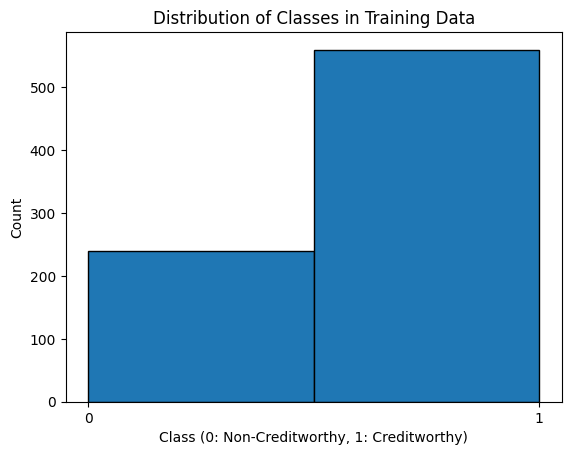

Class distribution in training set:
Creditability
1    560
0    240
Name: count, dtype: int64


In [15]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

# Print class distribution
print("Class distribution in training set:")
print(y_train.value_counts())

In [28]:
from imblearn.pipeline import Pipeline as ImbPipeline
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print("Best parameters for Random Forest:")
print(rf_grid_search.best_params_)

rf_best_model = rf_grid_search.best_estimator_

rf_pred_proba = rf_best_model.predict_proba(X_test)[:, 1]
rf_pred = rf_best_model.predict(X_test)

rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)

print("\nRandom Forest метрики:")
print(f"ROC AUC: {rf_roc_auc:.2f}")
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")

gb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.1, 0.05, 0.01],
    'classifier__max_depth': [3, 5, 7],
}

gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
gb_grid_search.fit(X_train, y_train)

print("Best parameters for Gradient Boosting:")
print(gb_grid_search.best_params_)

gb_best_model = gb_grid_search.best_estimator_

gb_pred_proba = gb_best_model.predict_proba(X_test)[:, 1]
gb_pred = gb_best_model.predict(X_test)

gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_precision = precision_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred)

print("\nGradient Boosting метрики:")
print(f"ROC AUC: {gb_roc_auc:.2f}")
print(f"Accuracy: {gb_accuracy:.2f}")
print(f"Precision: {gb_precision:.2f}")
print(f"Recall: {gb_recall:.2f}")

Best parameters for Random Forest:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}

Random Forest метрики:
ROC AUC: 0.82
Accuracy: 0.79
Precision: 0.81
Recall: 0.91
Best parameters for Gradient Boosting:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}

Gradient Boosting метрики:
ROC AUC: 0.80
Accuracy: 0.77
Precision: 0.82
Recall: 0.86


In [27]:
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mlp_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', MLPClassifier(max_iter=2000, random_state=42))
])

mlp_param_distributions = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 100, 50)],
    'classifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': uniform(0.0001, 0.01),  
    'classifier__learning_rate': ['constant', 'adaptive', 'invscaling'],
    'classifier__learning_rate_init': uniform(0.001, 0.1), 
}

mlp_random_search = RandomizedSearchCV(
    mlp_pipeline, 
    mlp_param_distributions, 
    n_iter=20,  
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1, 
    random_state=42, 
    verbose=1
)

mlp_random_search.fit(X_train, y_train)

print("Best parameters for MLP:")
print(mlp_random_search.best_params_)

mlp_best_model = mlp_random_search.best_estimator_

mlp_pred_proba = mlp_best_model.predict_proba(X_test)[:, 1]
mlp_pred = mlp_best_model.predict(X_test)

mlp_roc_auc = roc_auc_score(y_test, mlp_pred_proba)
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred)
mlp_recall = recall_score(y_test, mlp_pred)

print("\nMLP (Neural Network) метрики:")
print(f"ROC AUC: {mlp_roc_auc:.2f}")
print(f"Accuracy: {mlp_accuracy:.2f}")
print(f"Precision: {mlp_precision:.2f}")
print(f"Recall: {mlp_recall:.2f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for MLP:
{'classifier__activation': 'identity', 'classifier__alpha': np.float64(0.003012291401980419), 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate': 'invscaling', 'classifier__learning_rate_init': np.float64(0.014949386065204184), 'classifier__solver': 'lbfgs'}

MLP (Neural Network) метрики:
ROC AUC: 0.82
Accuracy: 0.74
Precision: 0.87
Recall: 0.74


## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели